In [706]:
import datetime
from datetime import date

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
import yfinance as yfin
from matplotlib import pyplot as plt

pd.options.display.float_format = "{:,.3f}".format
yfin.pdr_override()

In [707]:
# start = datetime.date.today()-datetime.timedelta(365*10)
# end = datetime.date.today()
start = datetime.date.today() - datetime.timedelta(365 * 10)
end = datetime.date.today()

prices = web.DataReader(["^GSPC", "^RUT"], start, end)["Adj Close"]

# Rename column to make names more intuitive
prices = prices.rename(columns={"^GSPC": "SP500", "^RUT": "Russell2000"})

[*********************100%%**********************]  2 of 2 completed


In [708]:
prices.head()

,SP500,Russell2000
Date,,
2013-09-10,"1,683.990","1,055.720"
2013-09-11,"1,689.130","1,055.340"
2013-09-12,"1,683.420","1,048.480"
2013-09-13,"1,687.990","1,053.980"
2013-09-16,"1,697.600","1,056.250"


In [709]:
df = np.log(prices) - np.log(prices.shift(1))
df = df.iloc[1:, :]
df.head()

,SP500,Russell2000
Date,,
2013-09-11,0.003,-0.000
2013-09-12,-0.003,-0.007
2013-09-13,0.003,0.005
2013-09-16,0.006,0.002
2013-09-17,0.004,0.010


In [710]:
df.mean() * 100
daily_returns = df.mean()

In [711]:
SP500_return = (np.exp(daily_returns * 252 * 10) * 1000)[0]
R2000_return = (np.exp(daily_returns * 252 * 10) * 1000)[1]
# with 252 trading days in a year, 10 years and 1000$ starting investment; we expect the following ROI at the end of 10 years
print(f"SP500 expected return per $1000 after 10 years: ${SP500_return}")
print(f"R2000 expected return per $1000 after 10 years: ${R2000_return}")

SP500 expected return per $1000 after 10 years: $2648.3232300073173
R2000 expected return per $1000 after 10 years: $1759.7869740900712


In [712]:
currYear = prices.loc[
    date.today() - datetime.timedelta(365) : date.today()  # noqa E203
]
currYear.max() - currYear.min()

SP500         1,011.930
Russell2000     347.300
dtype: float64

In [713]:
currYear.head()

,SP500,Russell2000
Date,,
2022-09-08,"4,006.180","1,846.910"
2022-09-09,"4,067.360","1,882.850"
2022-09-12,"4,110.410","1,906.090"
2022-09-13,"3,932.690","1,831.570"
2022-09-14,"3,946.010","1,838.460"


In [714]:
(currYear.max() - currYear.min()) / prices.iloc[-1]
# SP500 is more volatile, ineterestingly.

SP500         0.227
Russell2000   0.187
dtype: float64

In [715]:
prices.head()

,SP500,Russell2000
Date,,
2013-09-10,"1,683.990","1,055.720"
2013-09-11,"1,689.130","1,055.340"
2013-09-12,"1,683.420","1,048.480"
2013-09-13,"1,687.990","1,053.980"
2013-09-16,"1,697.600","1,056.250"


In [716]:
# Calculate 50-day moving averages.
prices["SP500 50ma"] = prices.SP500.rolling(50).mean()
prices["Russell2000 50ma"] = prices.Russell2000.rolling(50).mean()
prices.tail()

,SP500,Russell2000,SP500 50ma,Russell2000 50ma
Date,,,,
2023-08-31,"4,507.660","1,899.680","4,466.838","1,911.404"
2023-09-01,"4,515.770","1,920.830","4,469.515","1,912.857"
2023-09-05,"4,496.830","1,880.450","4,472.485","1,914.033"
2023-09-06,"4,465.480","1,874.280","4,475.219","1,915.054"
2023-09-07,"4,451.140","1,855.760","4,476.673","1,915.170"


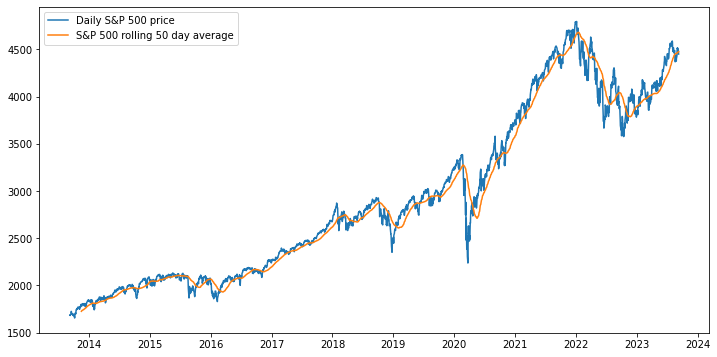

In [717]:
fig, axs = plt.subplots(figsize = (12, 6))
axs.plot(prices["SP500"], label="Daily S&P 500 price")
axs.plot(prices["SP500 50ma"], label="S&P 500 rolling 50 day average")
axs.legend(loc = 2)

In [718]:
(abs(prices - prices.rolling(50).mean()) / prices).mean()
# According to this metric, Russell2000 is more volatile.

SP500              0.029
Russell2000        0.038
SP500 50ma         0.021
Russell2000 50ma   0.026
dtype: float64

In [719]:
# Using standard deviation for volatility
prices[["SP500", "Russell2000"]].std()
# It is better to use this on returns.

SP500         887.687
Russell2000   354.959
dtype: float64

In [720]:
df[["SP500", "Russell2000"]].std()
# Russell2000 is more volatile according to standard deviation.

SP500         0.011
Russell2000   0.014
dtype: float64

In [721]:
startTime = datetime.date.today() - datetime.timedelta(365 * 10)
endTime = datetime.date.today()
tickers = {"^GSPC":"SP500", "^RUT":"Russell2000"}

In [722]:
print(type(tickers.keys()))
print(tickers.keys())
keylist = list(tickers.keys())
print(keylist)

<class 'dict_keys'>
dict_keys(['^GSPC', '^RUT'])
['^GSPC', '^RUT']


In [723]:
def investCompare(startTime, endTime, tickers):
    """Compares different volatility metrics in current year

    Args:
        startTime (datetime): starting date
        endTime (datetime): ending date
        tickers (dict): tickers to download from yfinance, keys are for yfinance, values are dataframe columns to be created from the corresponding keys
    
    Returns:
        investments (pandas.dataframe): a dataframe object
    """
    
    # get price data
    prices = web.DataReader(list(tickers.keys()), startTime, endTime)["Adj Close"]
    # rename columns
    prices = prices.rename(columns=tickers)
    # create returns dataframe
    returns = np.log(prices) - np.log(prices.shift(1))
    returns = returns.iloc[1:, 0:]  # drop first row because it is NaN
    # create current year dataframe
    prices_CurrYear = prices.loc[(date.today() - datetime.timedelta(365)):date.today()]
    
    # High-Low volatility
    highLow = (prices_CurrYear.max() - prices_CurrYear.min()) / prices.iloc[-1]
    highLow = pd.DataFrame(highLow, columns = ["HighMinusLow"])
    
    # Moving average volatility
    MA = pd.DataFrame((abs(prices - prices.rolling(50).mean()) / prices.mean()).mean(), columns = ["MA Vol"])
    
    # Stdev of returns volatility
    stDev = pd.DataFrame(returns.std(), columns = ["StandardDeviation"])
    
    # Mean daily returns
    meanDailyReturn = pd.DataFrame(returns.mean()*100, columns = ["Mean Daily Return (%)"])
    
    # merge datasets
    investments = highLow
    investments["MA Vol"] = MA["MA Vol"]
    investments["StandardDeviation"] = stDev["StandardDeviation"]
    investments["Mean Daily Return (%)"] = meanDailyReturn["Mean Daily Return (%)"]
    
    return investments

In [724]:
temp = investCompare(
    datetime.date(2020, 1, 1),
    datetime.date.today(),
    {"^GSPC": "SP500", "^RUT": "Russell2000"},
)
temp

[*********************100%%**********************]  2 of 2 completed


,HighMinusLow,MA Vol,StandardDeviation,Mean Daily Return (%)
SP500,0.227,0.036,0.015,0.034
Russell2000,0.187,0.048,0.019,0.012


In [725]:
# Try another example:
investCompare(
    datetime.date(2020, 1, 1),
    datetime.date.today(),
    {"^GSPC": "SP500", "^RUT": "Russell2000", "AAPL": "Apple"},
)

[*********************100%%**********************]  3 of 3 completed


,HighMinusLow,MA Vol,StandardDeviation,Mean Daily Return (%)
Apple,0.404,0.062,0.022,0.096
SP500,0.227,0.036,0.015,0.034
Russell2000,0.187,0.048,0.019,0.012


In [726]:
investCompare(
    datetime.date(2020, 1, 1), datetime.date.today(), {"VUG": "Growth", "VTV": "Value"}
)

[*********************100%%**********************]  2 of 2 completed


,HighMinusLow,MA Vol,StandardDeviation,Mean Daily Return (%)
Value,0.184,0.031,0.014,0.028
Growth,0.302,0.048,0.017,0.050


In [727]:
investCompare(
    datetime.date(2010, 1, 1), datetime.date.today(), {"VUG": "Growth", "VTV": "Value"}
)

[*********************100%%**********************]  2 of 2 completed


,HighMinusLow,MA Vol,StandardDeviation,Mean Daily Return (%)
Value,0.184,0.028,0.011,0.041
Growth,0.302,0.038,0.012,0.053


In [728]:
investCompare(
    datetime.date(2020, 1, 1),
    datetime.date.today(),
    {"^GSPC": "SP500", "SPEU": "Europe ETF", "GXC": "China ETF"},
)

[*********************100%%**********************]  3 of 3 completed


,HighMinusLow,MA Vol,StandardDeviation,Mean Daily Return (%)
China ETF,0.444,0.053,0.019,-0.035
Europe ETF,0.323,0.040,0.015,0.013
SP500,0.227,0.036,0.015,0.034


In [729]:
investCompare(
    datetime.date(2010, 1, 1),
    datetime.date.today(),
    {"^GSPC": "SP500", "SPEU": "Europe ETF", "GXC": "China ETF"},
)

[*********************100%%**********************]  3 of 3 completed


,HighMinusLow,MA Vol,StandardDeviation,Mean Daily Return (%)
China ETF,0.444,0.046,0.016,0.007
Europe ETF,0.323,0.033,0.013,0.014
SP500,0.227,0.030,0.011,0.040
